# COCO Reader

This reader operator reads a COCO dataset, or subset of COCO, which consists of an annotation file and the images directory.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
import os
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import random

import nvidia.dali.experimental.dynamic as ndd

dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
file_root = dali_extra_dir / "db" / "coco" / "images"
annotations_file = dali_extra_dir / "db" / "coco" / "instances.json"
batch_size = 16

In [2]:
reader = ndd.readers.COCO(
    file_root=file_root,
    annotations_file=annotations_file,
    polygon_masks=True,
    ratio=True,
)

for jpegs, bboxes, labels, polygons, vertices in reader.next_epoch(
    batch_size=batch_size
):
    images = ndd.decoders.image(jpegs, device="gpu")
    break  # Run once

The operator returns bounding boxes as 2D arrays of `float`. The inner dimension contains `[x, y, width, height]` by default. When `ltrb` parameter is set to `True`, the inner dimesion contains `[left, top, right, bottom]`.

In [3]:
sample_bboxes = np.asarray(bboxes.select(4))
sample_labels = np.asarray(labels.select(4))

for bbox, label in zip(sample_bboxes, sample_labels):
    x, y, width, height = bbox
    print(
        f"Bounding box (x={x}, y={y}, width={width}, height={height}), "
        f"label={label}"
    )

Bounding box (x=0.125, y=0.1794569045305252, width=0.3226562440395355, height=0.46871310472488403), label=1


The mask polygons are defined by two outputs: polygons and vertices. Each entry in polygons contains three integers, representing the mask index that the polygon belongs to, the start vertex index and one past the last vertex index that belongs to the polygon. Each entry in vertices contains coordinates (x, y) representing a polygon vertex.

In [4]:
sample_polygons = np.asarray(polygons.select(4))
sample_vertices = np.asarray(vertices.select(4))
print(sample_polygons.shape, sample_vertices.shape)

(1, 3) (26, 2)


In [5]:
for polygon in sample_polygons:
    mask_idx, start_vertex, end_vertex = polygon
    nvertices = end_vertex - start_vertex
    print(
        f"Polygon belonging to mask index {mask_idx} containing {nvertices} "
        "vertices:"
    )
    polygon_vertices = sample_vertices[start_vertex:end_vertex]
    for vertex_id in range(nvertices):
        x, y = sample_vertices[vertex_id]
        print(f"Vertex {vertex_id}: x={x}, y={y}")

Polygon belonging to mask index 0 containing 26 vertices:
Vertex 0: x=0.17783120274543762, y=0.23328186571598053
Vertex 1: x=0.1417735069990158, y=0.29483649134635925
Vertex 2: x=0.12574785947799683, y=0.38767293095588684
Vertex 3: x=0.13042201101779938, y=0.48959121108055115
Vertex 4: x=0.15646366775035858, y=0.572336733341217
Vertex 5: x=0.19853098690509796, y=0.6238003969192505
Vertex 6: x=0.23392093181610107, y=0.6490277647972107
Vertex 7: x=0.3073717951774597, y=0.6460005044937134
Vertex 8: x=0.36479702591896057, y=0.6449913382530212
Vertex 9: x=0.41554489731788635, y=0.6016004085540771
Vertex 10: x=0.4435897469520569, y=0.5097730755805969
Vertex 11: x=0.44826388359069824, y=0.4018002450466156
Vertex 12: x=0.43223825097084045, y=0.31199103593826294
Vertex 13: x=0.39684829115867615, y=0.24034550786018372
Vertex 14: x=0.35611647367477417, y=0.20502729713916779
Vertex 15: x=0.3213942348957062, y=0.20200002193450928
Vertex 16: x=0.2986912429332733, y=0.20300911366939545
Vertex 17: x=0

To visualize the ground truth bounding boxes and mask polygons on the image do:

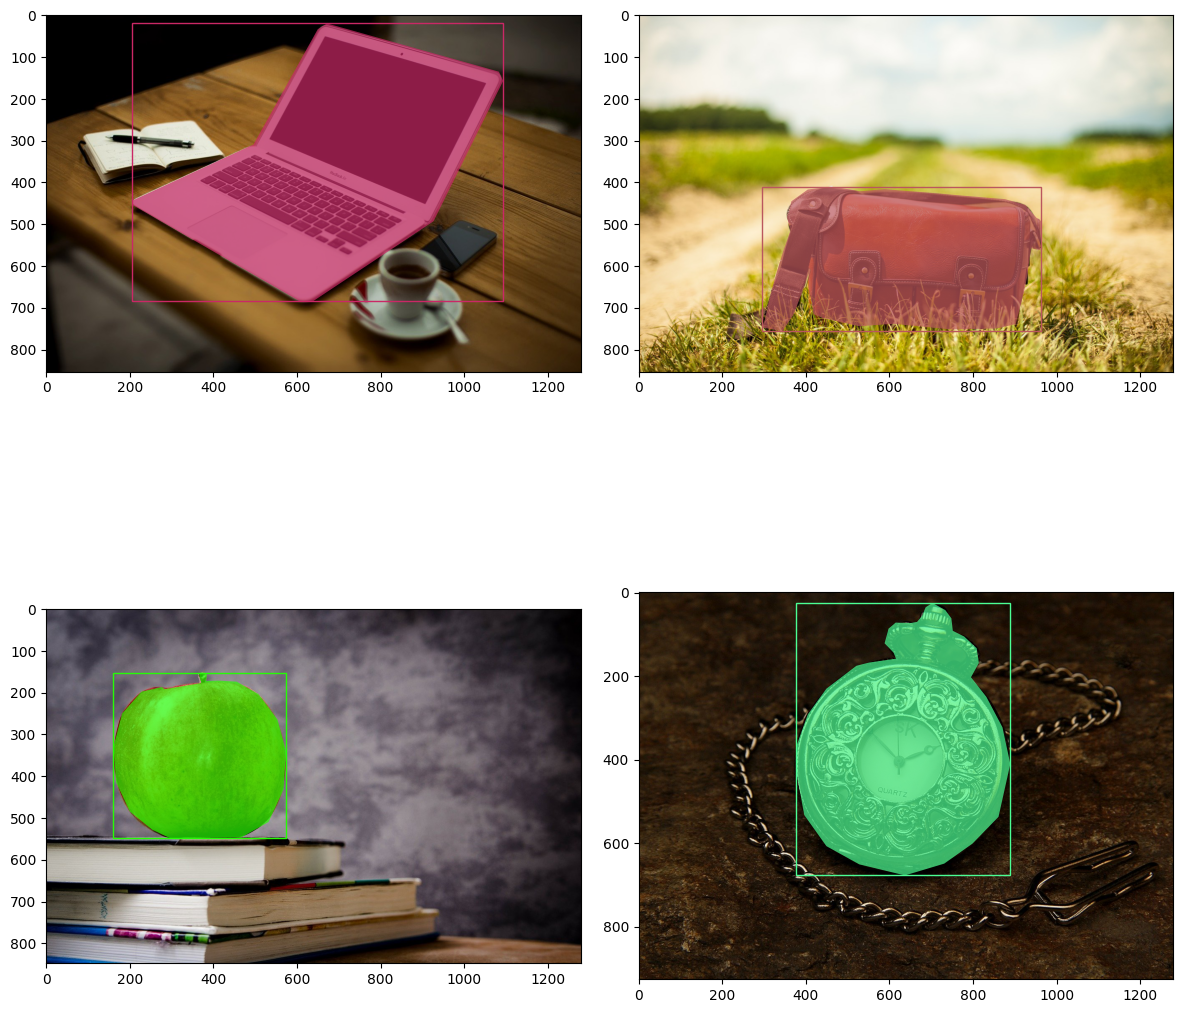

In [6]:
random.seed(1231243)


def plot_sample(img_index, ax):
    img = np.asarray(images.select(img_index).cpu())
    H, W = img.shape[:2]

    ax.imshow(img)
    sample_bboxes = np.asarray(bboxes.select(img_index))
    sample_labels = np.asarray(labels.select(img_index))
    sample_polygons = np.asarray(polygons.select(img_index))
    sample_vertices = np.asarray(vertices.select(img_index))

    categories_set = set(sample_labels.flatten())
    category_id_to_color = {
        cat_id: [
            random.uniform(0, 1),
            random.uniform(0, 1),
            random.uniform(0, 1),
        ]
        for cat_id in categories_set
    }

    for bbox, label in zip(sample_bboxes, sample_labels):
        label = int(label)
        rect = patches.Rectangle(
            (bbox[0] * W, bbox[1] * H),
            bbox[2] * W,
            bbox[3] * H,
            linewidth=1,
            edgecolor=category_id_to_color[label],
            facecolor="none",
        )
        ax.add_patch(rect)

    for polygon in sample_polygons:
        mask_idx, start_vertex, end_vertex = polygon
        polygon_vertices = sample_vertices[start_vertex:end_vertex]
        polygon_vertices = polygon_vertices * [W, H]
        poly = patches.Polygon(
            polygon_vertices,
            closed=True,
            facecolor=category_id_to_color[label],
            alpha=0.7,
        )
        ax.add_patch(poly)


fig, ax = plt.subplots(2, 2, figsize=(12, 12))
fig.tight_layout()
plot_sample(2, ax[0, 0])
plot_sample(1, ax[0, 1])
plot_sample(4, ax[1, 0])
plot_sample(8, ax[1, 1])
plt.show()